In [ ]:
import sys
import json
import pandas as pd
from pathlib import Path
import datetime as dt
import numpy as np
import seaborn as sb
from matplotlib import pyplot as plt
from scipy.stats import pearsonr

In [ ]:
PROJPATH = Path().resolve().parent
sys.path.append((PROJPATH / 'scripts').as_posix())
import riverice_util as ru

In [ ]:
prefix = "DD25"       # set to TDD for Thawing Degree Days

config = {
    "TDD": {
        "deltaT": 32
    },
    "DD20": {
        "deltaT": 20
    },
    "DD25": {
        "deltaT": 25
    },
}

breakupdata = PROJPATH / "data/breakupdata/derived"
stationdata = PROJPATH / f"data/weatherstations/ACIS/{prefix}/dd_cumul_bystation"
outpath = PROJPATH / "data/breakupdata/working"

### Helper functions

In [ ]:
def datestr2dayssince(datestr, since='0301'):
    thedate = dt.datetime.strptime(datestr, '%Y-%m-%d').date()
    since_mth = int(since[:2])
    since_day = int(since[3:])
    since_date = dt.date(thedate.year, since_mth, since_day)
    return (thedate - since_date).days

def datestr2julianday(datestr):
    thedate = dt.datetime.strptime(datestr, '%Y-%m-%d')
    return int(dt.datetime.strftime(thedate, '%j'))

In [ ]:
datestr2julianday('2010-03-01')

60

In [ ]:
def dayssince2date(days, year, since='0301'):
    since_date = dt.datetime.strptime(f"{year}{since}", "%Y%m%d").date()
    return (since_date + dt.timedelta(days=days))

def julianday2date(jd, year):
    since_date = dt.datetime.strptime(f"{year}{'0101'}", "%Y%m%d").date()
    return (since_date + dt.timedelta(days=jd-1))

In [ ]:
julianday2date(65, 2025)

datetime.date(2025, 3, 6)

In [ ]:
dayssince2date(43, 2022)

datetime.date(2022, 4, 13)

### Load data

In [ ]:
breakuppth = breakupdata / "breakupDate_cleaned_selected.csv"
breakup = pd.read_csv(breakuppth, header=3, index_col=0)
breakup 

,id,siteID,year,breakup,JulianDay
1909,209,Buckland River at Buckland,1983,1983-05-12,132
1908,210,Buckland River at Buckland,1984,1984-05-23,144
1757,1067,Buckland River at Buckland,1985,1985-05-26,146
1907,211,Buckland River at Buckland,1986,1986-05-30,150
1906,212,Buckland River at Buckland,1987,1987-05-22,142
...,...,...,...,...,...
197,7029,Yukon River nr Emmonak,2020,2020-05-14,135
157,7081,Yukon River nr Emmonak,2021,2021-05-13,133
113,7160,Yukon River nr Emmonak,2022,2022-05-15,135
52,7236,Yukon River nr Emmonak,2023,2023-05-27,147


In [ ]:
climatologies = pd.read_csv(PROJPATH / f"data/weatherstations/ACIS/{prefix}/all_cumul_clim1991_2020.csv", header=3, index_col=0)
climatologies

,GULKANA_AIRPORT,TANANA_AIRPORT,BETHEL_AIRPORT,ANCHORAGE_MERRILL_FIELD,EAGLE,BIG_DELTA_AIRPORT,KOTZEBUE_AIRPORT,SITKA_AIRPORT,MCGRATH_AP,TALKEETNA_AIRPORT,KENAI_AIRPORT,NORTH_POLE,NOME_AIRPORT,BETTLES_AIRPORT,NORTHWAY_AIRPORT,NENANA_MUNICIPAL_AIRPORT,CHICKEN,FAIRBANKS_INTL_AP,MCKINLEY_PARK
julian_day,,,,,,,,,,,,,,,,,,,
60,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.55,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
61,0.00,0.00,0.00,0.00,0.00,0.00,0.00,23.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
62,0.00,0.00,0.00,0.00,0.00,0.00,0.00,34.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
63,0.00,0.00,0.00,0.00,0.00,0.00,0.00,44.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
64,0.00,0.00,0.00,0.00,0.00,0.00,0.00,54.30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,1664.23,1690.27,1450.49,2093.64,1743.63,1873.33,820.74,2390.40,1789.57,1925.37,1736.62,1876.60,1034.40,1592.89,1690.51,1885.13,1460.43,1999.80,1449.03
179,1695.90,1725.65,1480.29,2128.51,1780.22,1909.02,849.02,2420.62,1825.57,1960.92,1766.57,1913.18,1058.78,1628.52,1724.68,1920.77,1490.41,2038.03,1478.93
180,1728.83,1761.58,1509.67,2163.79,1815.60,1945.06,878.18,2450.34,1861.45,1996.07,1796.44,1950.54,1083.93,1665.84,1759.73,1957.98,1518.68,2077.36,1510.33


In [ ]:
dd = sorted(list(stationdata.glob("*.csv")))

In [ ]:
def retrieve_dd(row, stationDF, offset=0):
    try:
        return stationDF.iloc[row.JulianDay-60-offset][str(row.year)]
    except KeyError:
        return np.nan

def retrieve_dd_anomaly(row, stationname, stationDF, offset=0):
    try:
        return stationDF.iloc[row.JulianDay-60-offset][str(row.year)] - climatologies[stationname].iloc[row.JulianDay-60-offset]
    except KeyError:
        return np.nan
    
def retrieve_dd_anomaly_fixed(row, stationname, stationDF, datestring):
    """Datestring is something like 04-15"""
    julian_day = datestr2julianday(f"{str(row.year)}-{datestring}")
    try:
        return stationDF.iloc[julian_day-60][str(row.year)] - climatologies[stationname].iloc[julian_day-60]
    except KeyError:
        return np.nan

### Prototyping: one location only

In [ ]:
location = "Yukon River at Eagle"
breakup = breakup[breakup.siteID == location].sort_values(by='year').reset_index(drop=True)
# breakup['days_since_march1'] = breakup.apply(lambda row: datestr2dayssince(row.breakup), axis=1)
breakup

,id,siteID,year,breakup,JulianDay
0,5330,Yukon River at Eagle,1980,1980-05-03,124
1,5331,Yukon River at Eagle,1981,1981-05-07,127
2,5332,Yukon River at Eagle,1982,1982-05-14,134
3,5333,Yukon River at Eagle,1983,1983-05-02,122
4,5334,Yukon River at Eagle,1984,1984-05-09,130
5,5335,Yukon River at Eagle,1985,1985-05-16,136
6,5336,Yukon River at Eagle,1986,1986-05-11,131
7,5337,Yukon River at Eagle,1987,1987-05-09,129
8,5338,Yukon River at Eagle,1988,1988-05-02,123
9,5339,Yukon River at Eagle,1989,1989-04-29,119


In [ ]:
teststationDF = pd.read_csv(dd[13], skiprows=4, index_col=0)
teststationDF

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
julian_day,,,,,,,,,,,,,,,,,,,,,
60,NaN,4.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,...,0.0,NaN,0.0,0.0,4.0,NaN,0.0,0.0,0.0,NaN
61,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,...,0.0,3.5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
62,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,7.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
63,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,7.0,0.0,0.0,8.5,0.0,0.0,3.5,0.0,0.0
64,1.0,7.0,0.5,0.0,0.0,5.0,0.0,0.0,3.0,0.0,...,0.0,7.0,0.0,3.0,13.0,0.0,0.0,3.5,4.0,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,1214.0,1378.0,968.0,1368.0,984.0,666.0,1015.5,1123.5,1301.0,883.0,...,1205.5,1477.5,1375.5,1156.0,1365.0,1513.0,1287.0,1327.0,923.5,1110.0
179,1236.5,1396.5,1000.5,1400.0,1016.0,679.5,1040.0,1152.5,1320.5,899.5,...,1227.5,1500.5,1401.0,1188.5,1398.0,1532.5,1313.0,1351.5,951.0,1143.0
180,1255.0,1416.0,1028.0,1421.5,1044.0,696.5,1070.0,1185.0,1345.5,925.5,...,1248.0,1527.5,1428.0,1218.0,1425.0,1552.5,1339.5,1377.0,978.0,1169.5


In [ ]:
breakup_anomaly = breakup.copy()

# for pth in dd:
#     stationname = pth.stem[:-17]
#     teststationDF = pd.read_csv(pth, skiprows=4, index_col=0)
#     breakup[stationname] = breakup.apply(
#         lambda row: retrieve_dd(row, teststationDF), axis=1)

for pth in dd:
    stationname = pth.stem[:-18]
    teststationDF = pd.read_csv(pth, skiprows=4, index_col=0)
    breakup_anomaly[stationname] = breakup_anomaly.apply(
        lambda row: retrieve_dd_anomaly(row, stationname, teststationDF), axis=1)

In [ ]:
breakup_anomaly

,id,siteID,year,breakup,JulianDay,ANCHORAGE_MERRILL_FIELD,BETHEL_AIRPORT,BETTLES_AIRPORT,BIG_DELTA_AIRPORT,CHICKEN,...,KOTZEBUE_AIRPORT,MCGRATH_AP,MCKINLEY_PARK,NENANA_MUNICIPAL_AIRPORT,NOME_AIRPORT,NORTHWAY_AIRPORT,NORTH_POLE,SITKA_AIRPORT,TALKEETNA_AIRPORT,TANANA_AIRPORT
0,5330,Yukon River at Eagle,1980,1980-05-03,124,NaN,138.88,32.12,262.05,NaN,...,31.00,129.91,86.76,NaN,132.64,113.01,98.52,53.65,98.55,47.84
1,5331,Yukon River at Eagle,1981,1981-05-07,127,NaN,270.71,28.07,175.83,NaN,...,88.00,136.43,133.49,NaN,127.54,10.32,116.71,136.05,44.88,98.10
2,5332,Yukon River at Eagle,1982,1982-05-14,134,NaN,-42.04,-110.50,-115.49,NaN,...,8.69,-86.47,-66.47,NaN,1.92,-113.24,-118.30,-169.22,-107.17,-85.14
3,5333,Yukon River at Eagle,1983,1983-05-02,122,NaN,39.69,100.51,55.67,NaN,...,141.00,19.86,95.68,NaN,115.18,75.58,0.42,115.68,49.43,99.53
4,5334,Yukon River at Eagle,1984,1984-05-09,130,NaN,18.18,-100.52,45.50,NaN,...,0.19,-138.80,42.56,NaN,3.05,46.91,-58.54,177.08,156.43,-122.36
5,5335,Yukon River at Eagle,1985,1985-05-16,136,NaN,-244.03,-128.90,-214.24,NaN,...,-57.34,-292.77,-178.86,NaN,-131.21,NaN,-217.51,-143.29,-280.17,-135.75
6,5336,Yukon River at Eagle,1986,1986-05-11,131,NaN,-24.77,-58.57,-166.25,NaN,...,26.90,-124.65,-103.13,NaN,-6.18,-155.29,-117.31,-93.24,-108.37,-68.57
7,5337,Yukon River at Eagle,1987,1987-05-09,129,NaN,69.78,36.36,86.98,NaN,...,24.19,55.45,51.30,NaN,89.92,33.74,100.92,39.08,101.11,86.67
8,5338,Yukon River at Eagle,1988,1988-05-02,123,NaN,64.86,160.44,152.65,NaN,...,132.50,95.26,113.86,NaN,132.56,38.31,120.23,5.55,59.45,175.94
9,5339,Yukon River at Eagle,1989,1989-04-29,119,NaN,32.94,67.55,105.23,NaN,...,69.50,71.22,85.31,NaN,54.78,127.65,79.79,15.11,31.71,100.29


In [ ]:
breakup_anomaly.columns

Index(['id', 'siteID', 'year', 'breakup', 'JulianDay',
       'ANCHORAGE_MERRILL_FIELD', 'BETHEL_AIRPORT', 'BETTLES_AIRPORT',
       'BIG_DELTA_AIRPORT', 'CHICKEN', 'EAGLE', 'FAIRBANKS_INTL_AP',
       'GULKANA_AIRPORT', 'KENAI_AIRPORT', 'KOTZEBUE_AIRPORT', 'MCGRATH_AP',
       'MCKINLEY_PARK', 'NENANA_MUNICIPAL_AIRPORT', 'NOME_AIRPORT',
       'NORTHWAY_AIRPORT', 'NORTH_POLE', 'SITKA_AIRPORT', 'TALKEETNA_AIRPORT',
       'TANANA_AIRPORT'],
      dtype='object')

BETHEL_AIRPORT


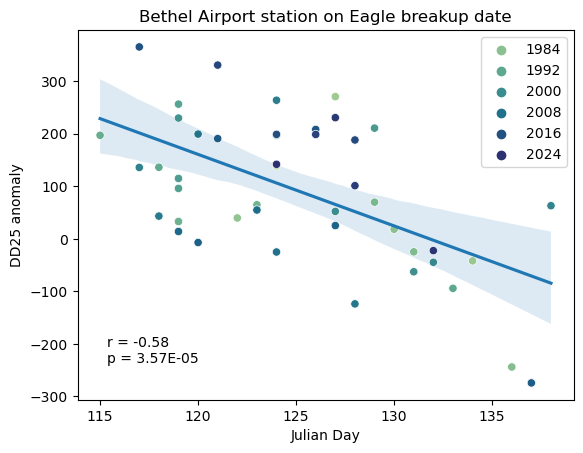

BETTLES_AIRPORT


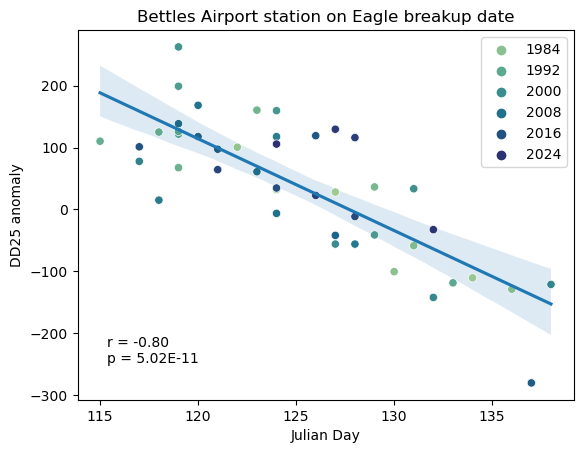

BIG_DELTA_AIRPORT


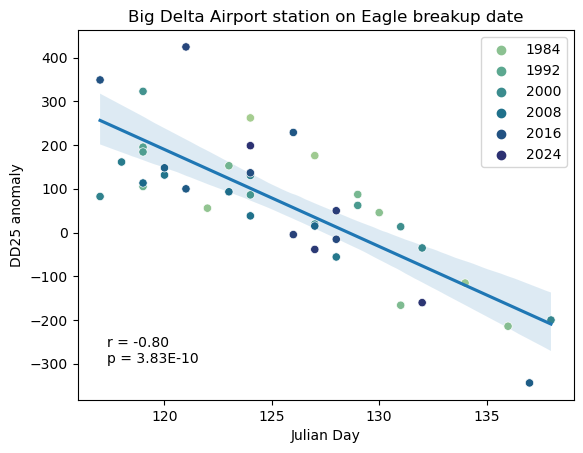

CHICKEN


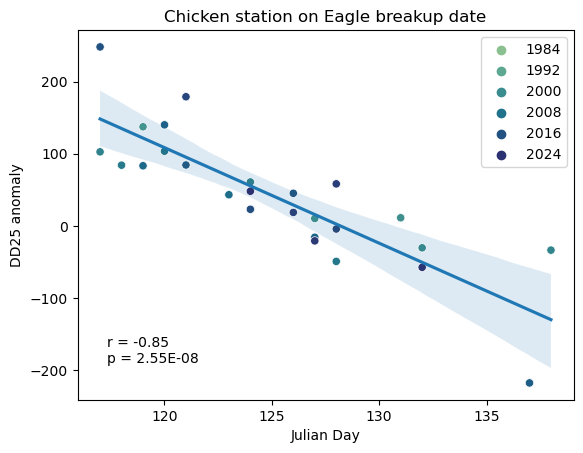

EAGLE


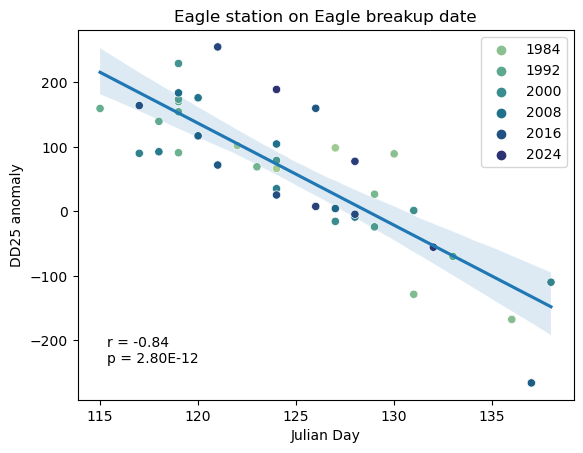

FAIRBANKS_INTL_AP


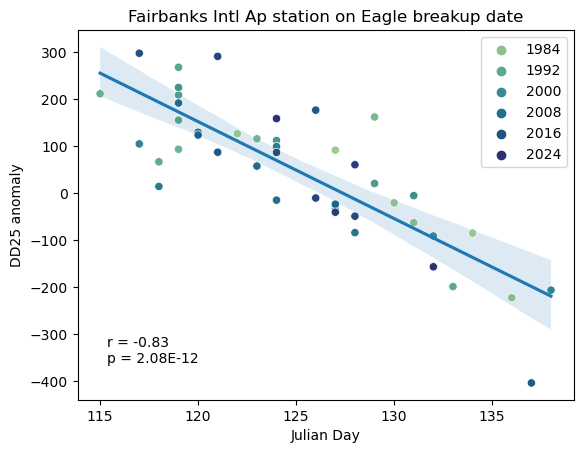

GULKANA_AIRPORT


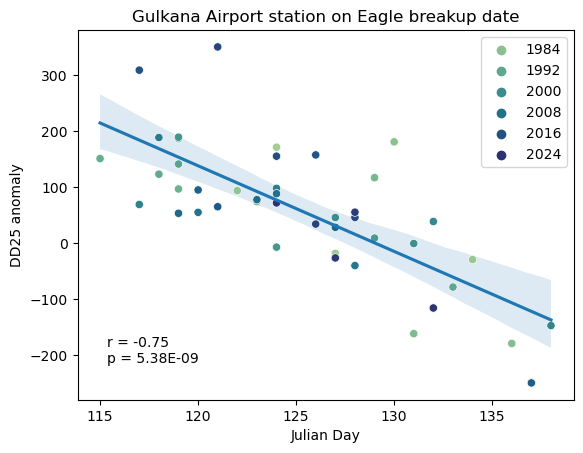

KENAI_AIRPORT


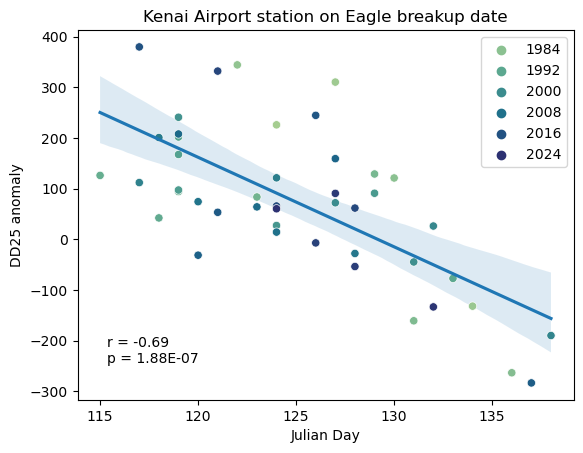

KOTZEBUE_AIRPORT


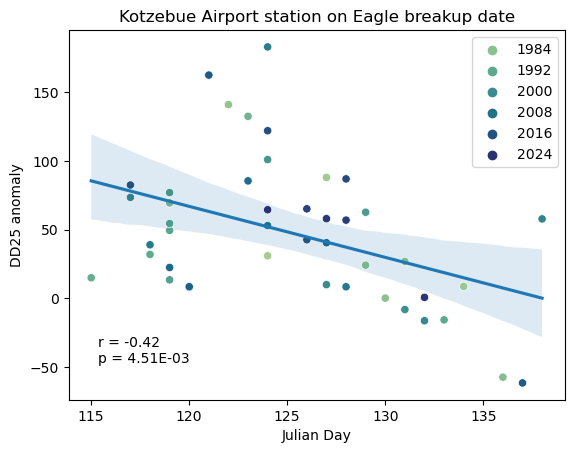

MCGRATH_AP


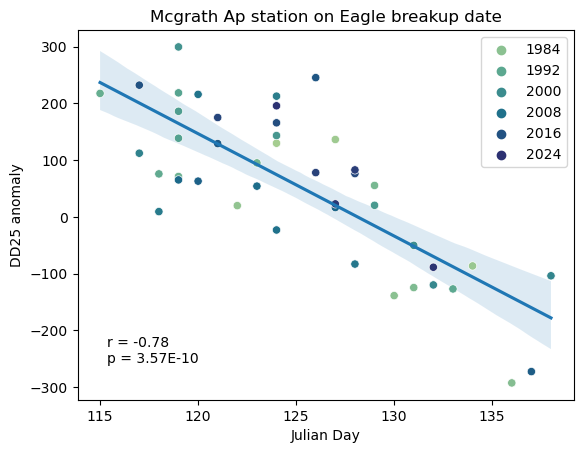

MCKINLEY_PARK


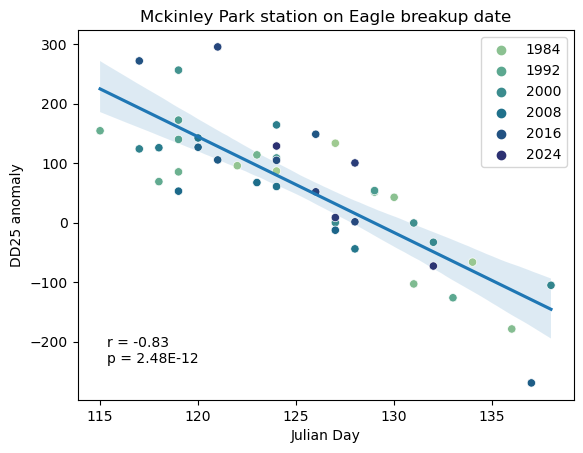

NENANA_MUNICIPAL_AIRPORT


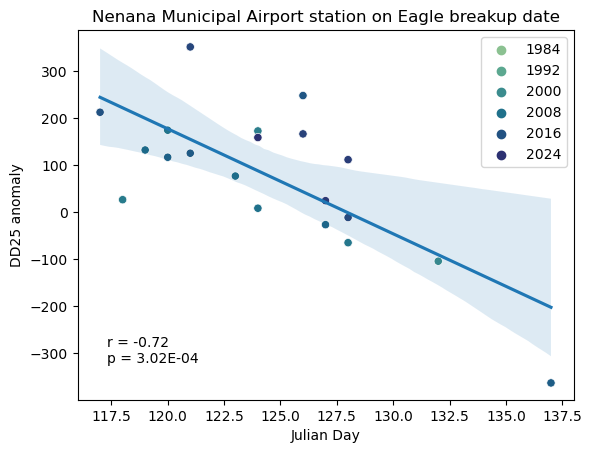

NOME_AIRPORT


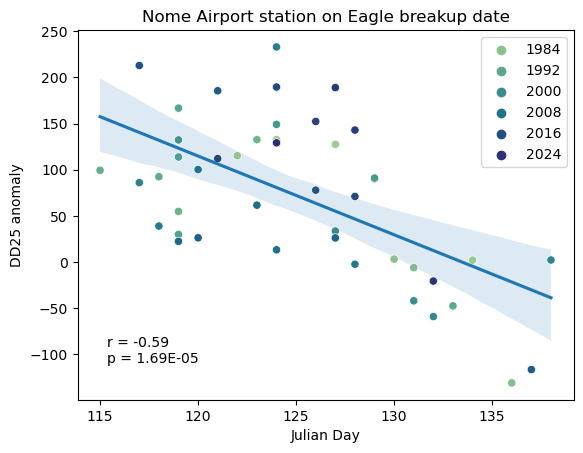

NORTHWAY_AIRPORT


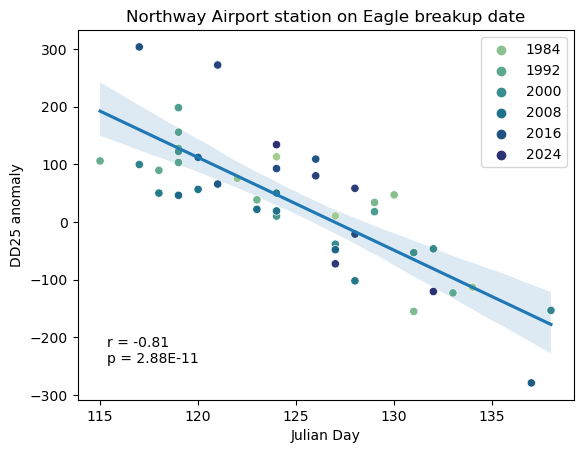

NORTH_POLE


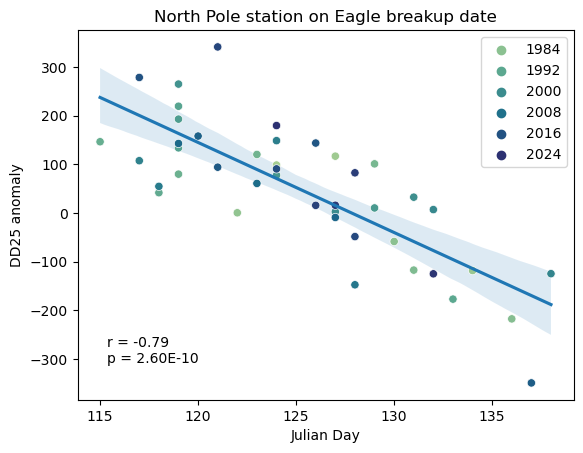

SITKA_AIRPORT


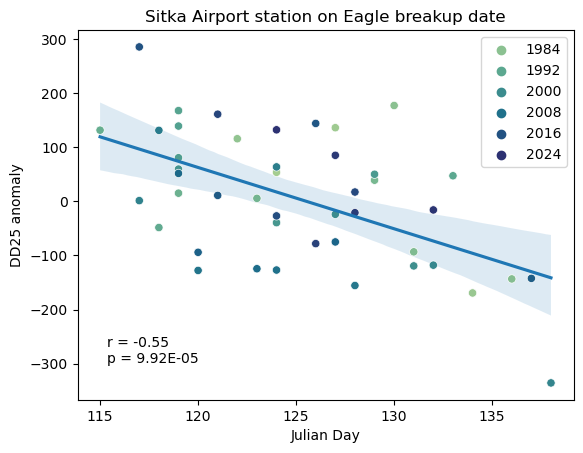

TALKEETNA_AIRPORT


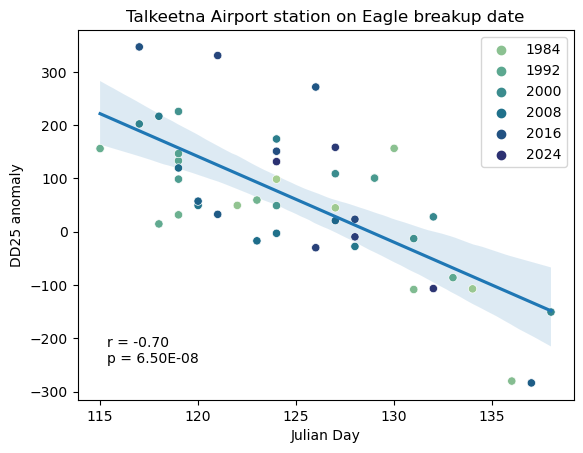

TANANA_AIRPORT


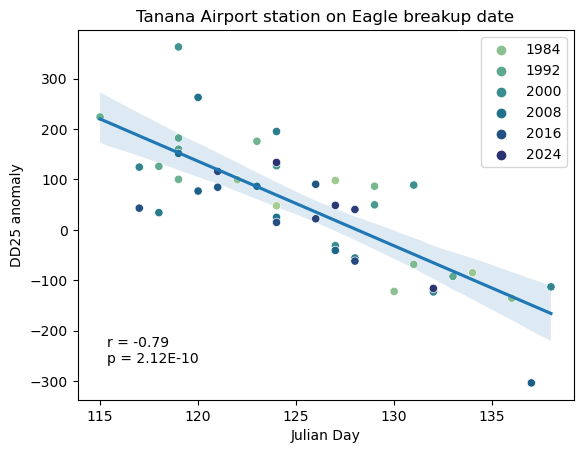

In [ ]:
for stationname in breakup_anomaly.columns[6:]:
    print(stationname)
    sb.regplot(data=breakup_anomaly, x='JulianDay', y=stationname, scatter=False)
    ax = sb.scatterplot(data=breakup_anomaly, x='JulianDay', y=stationname, hue='year', palette="crest")
    ax.set_title(f"{stationname.replace('_', ' ').title()} station on Eagle breakup date")
    ax.set_ylabel(f"{prefix} anomaly")
    ax.set_xlabel("Julian Day")
    plt.legend(loc='upper right')
    result = breakup_anomaly[stationname].corr(breakup_anomaly['JulianDay'],
                method=lambda x, y: pearsonr(x, y))
    ax.text(0.06, 0.1, f'r = {result.statistic:.2f}\np = {result.pvalue:.2E}', transform=ax.transAxes)
    plt.show()

In [ ]:
breakup_anomaly

,id,siteID,year,breakup,JulianDay,ANCHORAGE_MERRILL_FIELD,BETHEL_AIRPORT,BETTLES_AIRPORT,BIG_DELTA_AIRPORT,CHICKEN,...,KOTZEBUE_AIRPORT,MCGRATH_AP,MCKINLEY_PARK,NENANA_MUNICIPAL_AIRPORT,NOME_AIRPORT,NORTHWAY_AIRPORT,NORTH_POLE,SITKA_AIRPORT,TALKEETNA_AIRPORT,TANANA_AIRPORT
1909,209,Buckland River at Buckland,1983,1983-05-12,132,NaN,52.31,91.85,40.69,NaN,...,225.24,24.53,81.46,NaN,202.75,80.73,-36.45,114.66,58.40,80.64
1908,210,Buckland River at Buckland,1984,1984-05-23,144,NaN,5.83,-132.56,12.33,NaN,...,-49.37,-201.82,23.01,NaN,9.71,38.44,-66.01,192.89,138.79,-148.20
1757,1067,Buckland River at Buckland,1985,1985-05-26,146,NaN,-280.98,-160.48,-243.06,NaN,...,-78.46,-350.27,-212.99,NaN,-161.78,NaN,-219.69,-151.82,-315.26,-177.69
1907,211,Buckland River at Buckland,1986,1986-05-30,150,NaN,-120.90,-180.93,-282.35,NaN,...,-84.70,-211.55,-195.67,NaN,-116.83,-247.37,-217.34,-138.31,-132.36,-129.92
1906,212,Buckland River at Buckland,1987,1987-05-22,142,NaN,21.41,30.26,73.65,NaN,...,73.03,19.03,49.59,NaN,92.46,0.32,99.16,25.24,80.21,75.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,7029,Yukon River nr Emmonak,2020,2020-05-14,135,22.48,264.09,75.78,40.59,62.60,...,142.85,129.26,103.66,246.30,232.54,148.33,77.73,-18.84,13.86,64.65
157,7081,Yukon River nr Emmonak,2021,2021-05-13,133,-54.37,126.19,140.42,58.09,68.58,...,80.38,105.46,107.12,131.68,179.35,77.86,102.00,-27.91,-4.62,59.98
113,7160,Yukon River nr Emmonak,2022,2022-05-15,135,140.98,204.59,84.78,-113.91,-58.40,...,32.85,3.20,-54.84,-32.20,166.54,-116.17,-50.72,78.16,127.86,-9.85
52,7236,Yukon River nr Emmonak,2023,2023-05-27,147,-117.43,-43.17,8.20,-115.79,-13.97,...,-20.25,-74.51,-44.30,NaN,-27.15,-72.43,-70.53,52.43,-114.21,-114.66


In [ ]:
breakup

,id,siteID,year,breakup,JulianDay
0,5330,Yukon River at Eagle,1980,1980-05-03,124
1,5331,Yukon River at Eagle,1981,1981-05-07,127
2,5332,Yukon River at Eagle,1982,1982-05-14,134
3,5333,Yukon River at Eagle,1983,1983-05-02,122
4,5334,Yukon River at Eagle,1984,1984-05-09,130
5,5335,Yukon River at Eagle,1985,1985-05-16,136
6,5336,Yukon River at Eagle,1986,1986-05-11,131
7,5337,Yukon River at Eagle,1987,1987-05-09,129
8,5338,Yukon River at Eagle,1988,1988-05-02,123
9,5339,Yukon River at Eagle,1989,1989-04-29,119


In [ ]:
# breakup_only = breakup_anomaly[breakup_anomaly.columns[4:]]
breakup_only = breakup[breakup.columns[4:]]
breakup_standardized = ((breakup_only - breakup_only.mean())/breakup_only.std())
breakup_standardized

,JulianDay
0,-0.186640
1,0.327573
2,1.527404
3,-0.529449
4,0.841786
5,1.870213
6,1.013190
7,0.670382
8,-0.358045
9,-1.043662


In [ ]:
breakup

,id,siteID,year,breakup,JulianDay
1909,209,Buckland River at Buckland,1983,1983-05-12,132
1908,210,Buckland River at Buckland,1984,1984-05-23,144
1757,1067,Buckland River at Buckland,1985,1985-05-26,146
1907,211,Buckland River at Buckland,1986,1986-05-30,150
1906,212,Buckland River at Buckland,1987,1987-05-22,142
...,...,...,...,...,...
197,7029,Yukon River nr Emmonak,2020,2020-05-14,135
157,7081,Yukon River nr Emmonak,2021,2021-05-13,133
113,7160,Yukon River nr Emmonak,2022,2022-05-15,135
52,7236,Yukon River nr Emmonak,2023,2023-05-27,147


In [ ]:
mean_EAGLE = breakup['EAGLE'].mean()
mean_EAGLE

KeyError: 'EAGLE'

In [ ]:
breakup.apply(lambda row: climatologies.loc[row.JulianDay], axis=1)

,GULKANA_AIRPORT,TANANA_AIRPORT,BETHEL_AIRPORT,ANCHORAGE_MERRILL_FIELD,EAGLE,BIG_DELTA_AIRPORT,KOTZEBUE_AIRPORT,SITKA_AIRPORT,MCGRATH_AP,TALKEETNA_AIRPORT,KENAI_AIRPORT,NORTH_POLE,NOME_AIRPORT,BETTLES_AIRPORT,NORTHWAY_AIRPORT,NENANA_MUNICIPAL_AIRPORT,CHICKEN,FAIRBANKS_INTL_AP,MCKINLEY_PARK
0,285.07,184.66,178.62,536.67,225.62,320.45,0.00,1004.35,258.09,433.95,431.17,312.43,51.86,122.88,239.99,274.49,163.39,329.58,177.24
1,333.14,228.90,217.29,599.49,272.11,374.17,1.50,1066.45,308.07,488.12,484.36,363.68,71.46,158.43,288.68,326.75,204.11,385.71,214.01
2,463.29,362.14,327.04,761.61,414.05,526.49,48.31,1223.22,451.97,635.17,620.18,514.80,143.58,279.00,425.24,480.01,319.71,547.19,329.29
3,254.57,160.47,158.31,496.85,196.92,288.33,0.00,962.82,228.64,399.57,398.46,282.08,44.32,104.49,210.92,241.42,138.41,294.78,154.32
4,386.96,281.52,260.32,666.11,328.88,437.50,15.81,1131.42,365.80,548.57,540.96,426.04,99.95,205.52,343.59,388.70,251.68,451.94,260.20
5,503.22,405.75,365.03,811.26,456.45,573.24,65.34,1268.79,498.77,680.17,661.07,561.51,169.71,318.90,468.44,530.49,355.64,598.20,366.36
6,405.13,301.07,276.77,689.54,350.15,458.75,23.60,1154.24,386.65,569.37,560.59,447.00,110.68,223.07,362.29,410.20,268.13,475.01,277.13
7,368.91,263.33,244.72,643.11,308.44,416.02,9.31,1109.42,346.05,527.89,521.59,404.58,89.08,189.14,325.26,367.30,236.20,429.66,244.20
8,269.71,172.56,168.64,516.52,211.46,304.35,0.00,983.45,243.24,416.55,414.94,297.27,47.94,113.56,225.19,257.35,151.24,312.13,166.14
9,210.12,119.21,123.06,437.35,152.43,239.27,0.00,900.89,183.78,348.29,348.20,232.71,31.22,73.95,167.85,193.00,101.13,241.36,118.62


## Model breakup by DD anomaly for all locations

Load breakup data again and recalculate anomaly dataframe.

In [ ]:
breakuppth = breakupdata / "breakupDate_cleaned_selected.csv"
breakup = pd.read_csv(breakuppth, header=3, index_col=0)
breakup['JulianDay'] = breakup.apply(lambda row: datestr2julianday(row.breakup), axis=1)
breakup_anomaly = breakup.copy()

for pth in dd:
    stationname = pth.stem[:-14-len(prefix)]
    teststationDF = pd.read_csv(pth, skiprows=4, index_col=0)
    breakup_anomaly[stationname] = breakup_anomaly.apply(
        lambda row: retrieve_dd_anomaly(row, stationname, teststationDF), axis=1)

In [ ]:
locations = breakup.siteID.unique()
locations

array(['Buckland River at Buckland', 'Colville River at Colville Village',
       'Colville River at Umiat', 'Kobuk River at Ambler',
       'Kobuk River at Kobuk', 'Kobuk River at Shungnak',
       'Koyukuk River at Allakaket', 'Koyukuk River at Bettles',
       'Koyukuk River at Hughes', 'Kuskokwim River at Akiak',
       'Kuskokwim River at Aniak', 'Kuskokwim River at Bethel',
       'Kuskokwim River at Crooked Creek', 'Kuskokwim River at Kalskag',
       'Kuskokwim River at McGrath', 'Kuskokwim River at Napakiak',
       'Kuskokwim River at Nikolai', 'Kuskokwim River at Red Devil',
       'Kuskokwim River at Sleetmute', 'Kuskokwim River at Stony River',
       'Kuskokwim River at Tuluksak', 'Susitna River at Sunshine',
       'Tanana River at Fairbanks D-S of Chena R',
       'Tanana River at Nenana', 'Tanana River nr Manley Hot Springs',
       'Yukon River at Alakanuk', 'Yukon River at Anvik',
       'Yukon River at Beaver', 'Yukon River at Circle',
       'Yukon River at Dawson'

In [ ]:
breakup_anomaly

,id,siteID,year,breakup,JulianDay,ANCHORAGE_MERRILL_FIELD,BETHEL_AIRPORT,BETTLES_AIRPORT,BIG_DELTA_AIRPORT,CHICKEN,...,KOTZEBUE_AIRPORT,MCGRATH_AP,MCKINLEY_PARK,NENANA_MUNICIPAL_AIRPORT,NOME_AIRPORT,NORTHWAY_AIRPORT,NORTH_POLE,SITKA_AIRPORT,TALKEETNA_AIRPORT,TANANA_AIRPORT
1909,209,Buckland River at Buckland,1983,1983-05-12,132,NaN,52.31,91.85,40.69,NaN,...,225.24,24.53,81.46,NaN,202.75,80.73,-36.45,114.66,58.40,80.64
1908,210,Buckland River at Buckland,1984,1984-05-23,144,NaN,5.83,-132.56,12.33,NaN,...,-49.37,-201.82,23.01,NaN,9.71,38.44,-66.01,192.89,138.79,-148.20
1757,1067,Buckland River at Buckland,1985,1985-05-26,146,NaN,-280.98,-160.48,-243.06,NaN,...,-78.46,-350.27,-212.99,NaN,-161.78,NaN,-219.69,-151.82,-315.26,-177.69
1907,211,Buckland River at Buckland,1986,1986-05-30,150,NaN,-120.90,-180.93,-282.35,NaN,...,-84.70,-211.55,-195.67,NaN,-116.83,-247.37,-217.34,-138.31,-132.36,-129.92
1906,212,Buckland River at Buckland,1987,1987-05-22,142,NaN,21.41,30.26,73.65,NaN,...,73.03,19.03,49.59,NaN,92.46,0.32,99.16,25.24,80.21,75.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,7029,Yukon River nr Emmonak,2020,2020-05-14,135,22.48,264.09,75.78,40.59,62.60,...,142.85,129.26,103.66,246.30,232.54,148.33,77.73,-18.84,13.86,64.65
157,7081,Yukon River nr Emmonak,2021,2021-05-13,133,-54.37,126.19,140.42,58.09,68.58,...,80.38,105.46,107.12,131.68,179.35,77.86,102.00,-27.91,-4.62,59.98
113,7160,Yukon River nr Emmonak,2022,2022-05-15,135,140.98,204.59,84.78,-113.91,-58.40,...,32.85,3.20,-54.84,-32.20,166.54,-116.17,-50.72,78.16,127.86,-9.85
52,7236,Yukon River nr Emmonak,2023,2023-05-27,147,-117.43,-43.17,8.20,-115.79,-13.97,...,-20.25,-74.51,-44.30,NaN,-27.15,-72.43,-70.53,52.43,-114.21,-114.66


In [ ]:
def calculate_corr(breakupDF=breakup_anomaly, show_plots=False, save_plots=False, 
               prefix=f"{prefix}_breakupday", locations=locations, stationnames=None):
    if not set(locations) <= set(breakupDF.siteID):
        raise Exception("Sorry, the location isn't available in the breakup dataset. Check spelling?")
    outputrecords = []
    for location in locations:
        print(f"working on {location}")
        testDF = breakupDF[breakupDF.siteID == location].sort_values(
            by='year').reset_index(drop=True)
        if stationnames is None:
            stationnames = testDF.columns[5:]
        if not set(stationnames) <= set(breakupDF.columns):
            raise Exception(f"Sorry, the {stationnames} isn't in valid names: {breakupDF.columns}")
        for stationname in stationnames:
            result = testDF[stationname].corr(testDF['JulianDay'],
                        method=lambda x, y: pearsonr(x, y))
            outputrecords.append(
                {
                    "stationname": stationname,  
                    "location": location,
                    "pvalue": result.pvalue,
                    "rvalue": result.statistic,
                    "r2value": result.statistic**2
                }
            )        
            if show_plots or save_plots:
                sb.regplot(data=testDF, y='JulianDay', x=stationname, scatter=False)
                ax = sb.scatterplot(data=testDF, y='JulianDay', x=stationname, 
                                    hue='year', palette="crest")
                ax.set_title(f"{stationname.replace('_', ' ').title()} station for {location} "
                             f"{prefix.replace('_', ' ')}")
                ax.set_xlabel(f"{prefix} anomaly")
                ax.set_ylabel("Julian Day")
                plt.legend(loc='upper right')
                ax.text(0.06, 0.1, 
                        f'r = {result.statistic:.2f}\nr2 = {result.statistic**2:.2f}\np = {result.pvalue:.2E}', 
                        transform=ax.transAxes)
                if save_plots:
                    fn = f"{prefix}_{location.replace(' ', '_')}_AT_{stationname}.png"
                    plt.savefig(outpath / fn, bbox_inches='tight')
                    plt.close()
                if show_plots:
                    plt.show()
    return outputrecords
    

Make plots for all on breakup date

In [ ]:
outpath

PosixPath('/Users/chris/Projects/2023_Riverice/data/breakupdata/working')

In [ ]:
returnrec = calculate_corr(locations=['Yukon River at Eagle'], 
                           stationnames=['CHICKEN'], save_plots=True)

working on Yukon River at Eagle


In [ ]:
returnrec = calculate_corr()

working on Buckland River at Buckland
working on Colville River at Colville Village
working on Colville River at Umiat
working on Kobuk River at Ambler
working on Kobuk River at Kobuk
working on Kobuk River at Shungnak
working on Koyukuk River at Allakaket
working on Koyukuk River at Bettles
working on Koyukuk River at Hughes
working on Kuskokwim River at Akiak
working on Kuskokwim River at Aniak
working on Kuskokwim River at Bethel
working on Kuskokwim River at Crooked Creek
working on Kuskokwim River at Kalskag
working on Kuskokwim River at McGrath
working on Kuskokwim River at Napakiak
working on Kuskokwim River at Nikolai
working on Kuskokwim River at Red Devil
working on Kuskokwim River at Sleetmute
working on Kuskokwim River at Stony River
working on Kuskokwim River at Tuluksak
working on Susitna River at Sunshine
working on Tanana River at Fairbanks D-S of Chena R
working on Tanana River at Nenana
working on Tanana River nr Manley Hot Springs
working on Yukon River at Alakanuk
w

In [ ]:
resultsDF_p = pd.DataFrame.from_records(returnrec).pivot(
    index='location', columns='stationname', values='pvalue').fillna(1.0)
resultsDF_r2 = pd.DataFrame.from_records(returnrec).pivot(
    index='location', columns='stationname', values='r2value').fillna(0.0)

In [ ]:
resultsDF_r2

stationname,ANCHORAGE_MERRILL_FIELD,BETHEL_AIRPORT,BETTLES_AIRPORT,BIG_DELTA_AIRPORT,CHICKEN,EAGLE,FAIRBANKS_INTL_AP,GULKANA_AIRPORT,KENAI_AIRPORT,KOTZEBUE_AIRPORT,MCGRATH_AP,MCKINLEY_PARK,NENANA_MUNICIPAL_AIRPORT,NOME_AIRPORT,NORTHWAY_AIRPORT,NORTH_POLE,SITKA_AIRPORT,TALKEETNA_AIRPORT,TANANA_AIRPORT
location,,,,,,,,,,,,,,,,,,,
Buckland River at Buckland,0.077175,0.465826,0.433767,0.376981,0.436258,0.352783,0.375245,0.320696,0.230611,0.684437,0.424658,0.486425,0.463131,0.641748,0.424806,0.365867,0.193293,0.278220,0.250925
Colville River at Colville Village,0.072188,0.275251,0.060006,0.090169,0.130646,0.021496,0.080983,0.062424,0.047487,0.212698,0.098091,0.092035,0.237665,0.193538,0.060033,0.043686,0.021766,0.080305,0.048733
Colville River at Umiat,0.413829,0.181002,0.225088,0.291307,0.142553,0.192463,0.158711,0.245372,0.121752,0.228413,0.179178,0.233519,0.142826,0.069527,0.225064,0.276501,0.121037,0.179452,0.077263
Kobuk River at Ambler,0.109486,0.487880,0.557140,0.409192,0.646617,0.421244,0.494930,0.374507,0.248149,0.625688,0.447906,0.501573,0.607708,0.649390,0.474600,0.394800,0.180070,0.319033,0.349514
Kobuk River at Kobuk,0.146772,0.515311,0.688378,0.498887,0.668450,0.508963,0.554261,0.403567,0.320580,0.616188,0.644836,0.608932,0.604034,0.665779,0.529284,0.508932,0.163601,0.373554,0.518124
Kobuk River at Shungnak,0.181439,0.546395,0.755465,0.673207,0.832906,0.579972,0.642547,0.531954,0.364907,0.754501,0.658113,0.736955,0.751856,0.717997,0.673103,0.630665,0.177960,0.428595,0.613255
Koyukuk River at Allakaket,0.145826,0.371229,0.760955,0.390855,0.514641,0.573622,0.526584,0.335777,0.359209,0.459576,0.481823,0.497266,0.507747,0.497095,0.388482,0.391251,0.164702,0.337836,0.548229
Koyukuk River at Bettles,0.141062,0.302157,0.753670,0.358832,0.434012,0.487432,0.514346,0.256665,0.299970,0.412030,0.472040,0.454235,0.418038,0.473509,0.352928,0.387347,0.131710,0.242853,0.510776
Koyukuk River at Hughes,0.152859,0.426047,0.804405,0.504099,0.515567,0.613854,0.648544,0.420106,0.349628,0.378179,0.597686,0.588457,0.576144,0.511113,0.478004,0.520299,0.209463,0.368096,0.616736


In [ ]:
with open(outpath / f"breakupday_{prefix}_corr_pvalues.csv", "w") as dst:
    dst.write(f"# Correlations between Degree Days > {config[prefix]['deltaT']} (F) anomalies and breakup day \n")
    dst.write("# For all selected sites and stations\n")
    dst.write("# \n")
    resultsDF_p.to_csv(dst)
with open(outpath / f"breakupday_{prefix}_corr_r2values.csv", "w") as dst:
    dst.write(f"# Correlation R2 between Degree Days > {config[prefix]['deltaT']} (F) anomalies and breakup day \n")
    dst.write("# For all selected sites and stations\n")
    dst.write("# \n")
    resultsDF_r2.to_csv(dst)   

Text(0.5, 1.0, 'Pearson Rˆ2 of correlation between DD25 anomaly on breakup date, and breakup date')

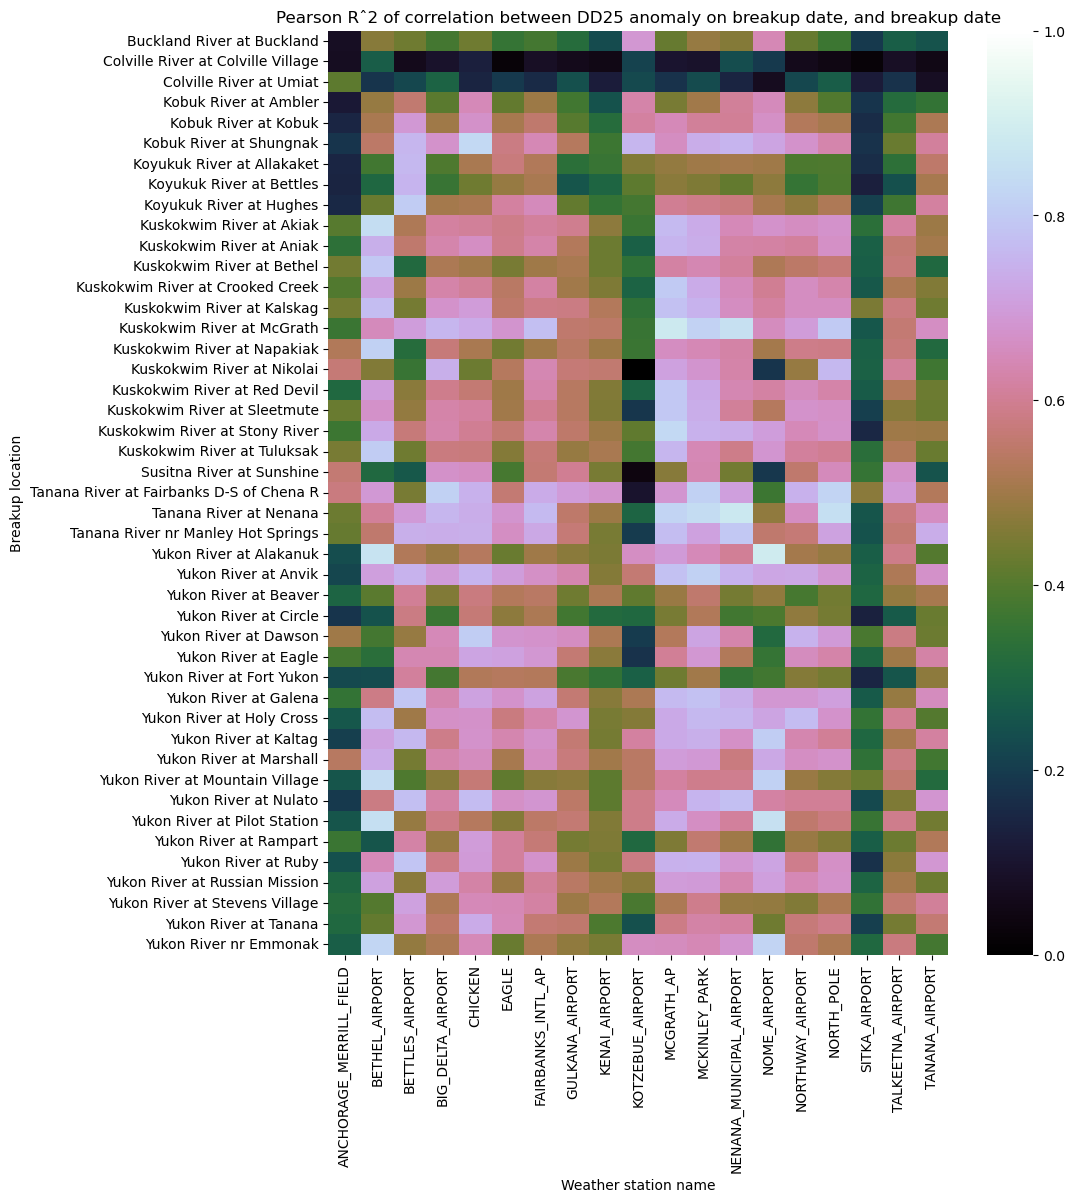

In [ ]:
plt.subplots(figsize=(10,12))
sb.heatmap(
    resultsDF_r2, 
    cmap='cubehelix', xticklabels=True, yticklabels=True, vmin=0, vmax=1)
plt.xlabel('Weather station name')
plt.ylabel('Breakup location')
plt.title(f"Pearson Rˆ2 of correlation between {prefix} anomaly on breakup date, and breakup date")

Text(0.5, 1.0, 'Log10 of p-value of correlation between TDD anomaly and breakup date')

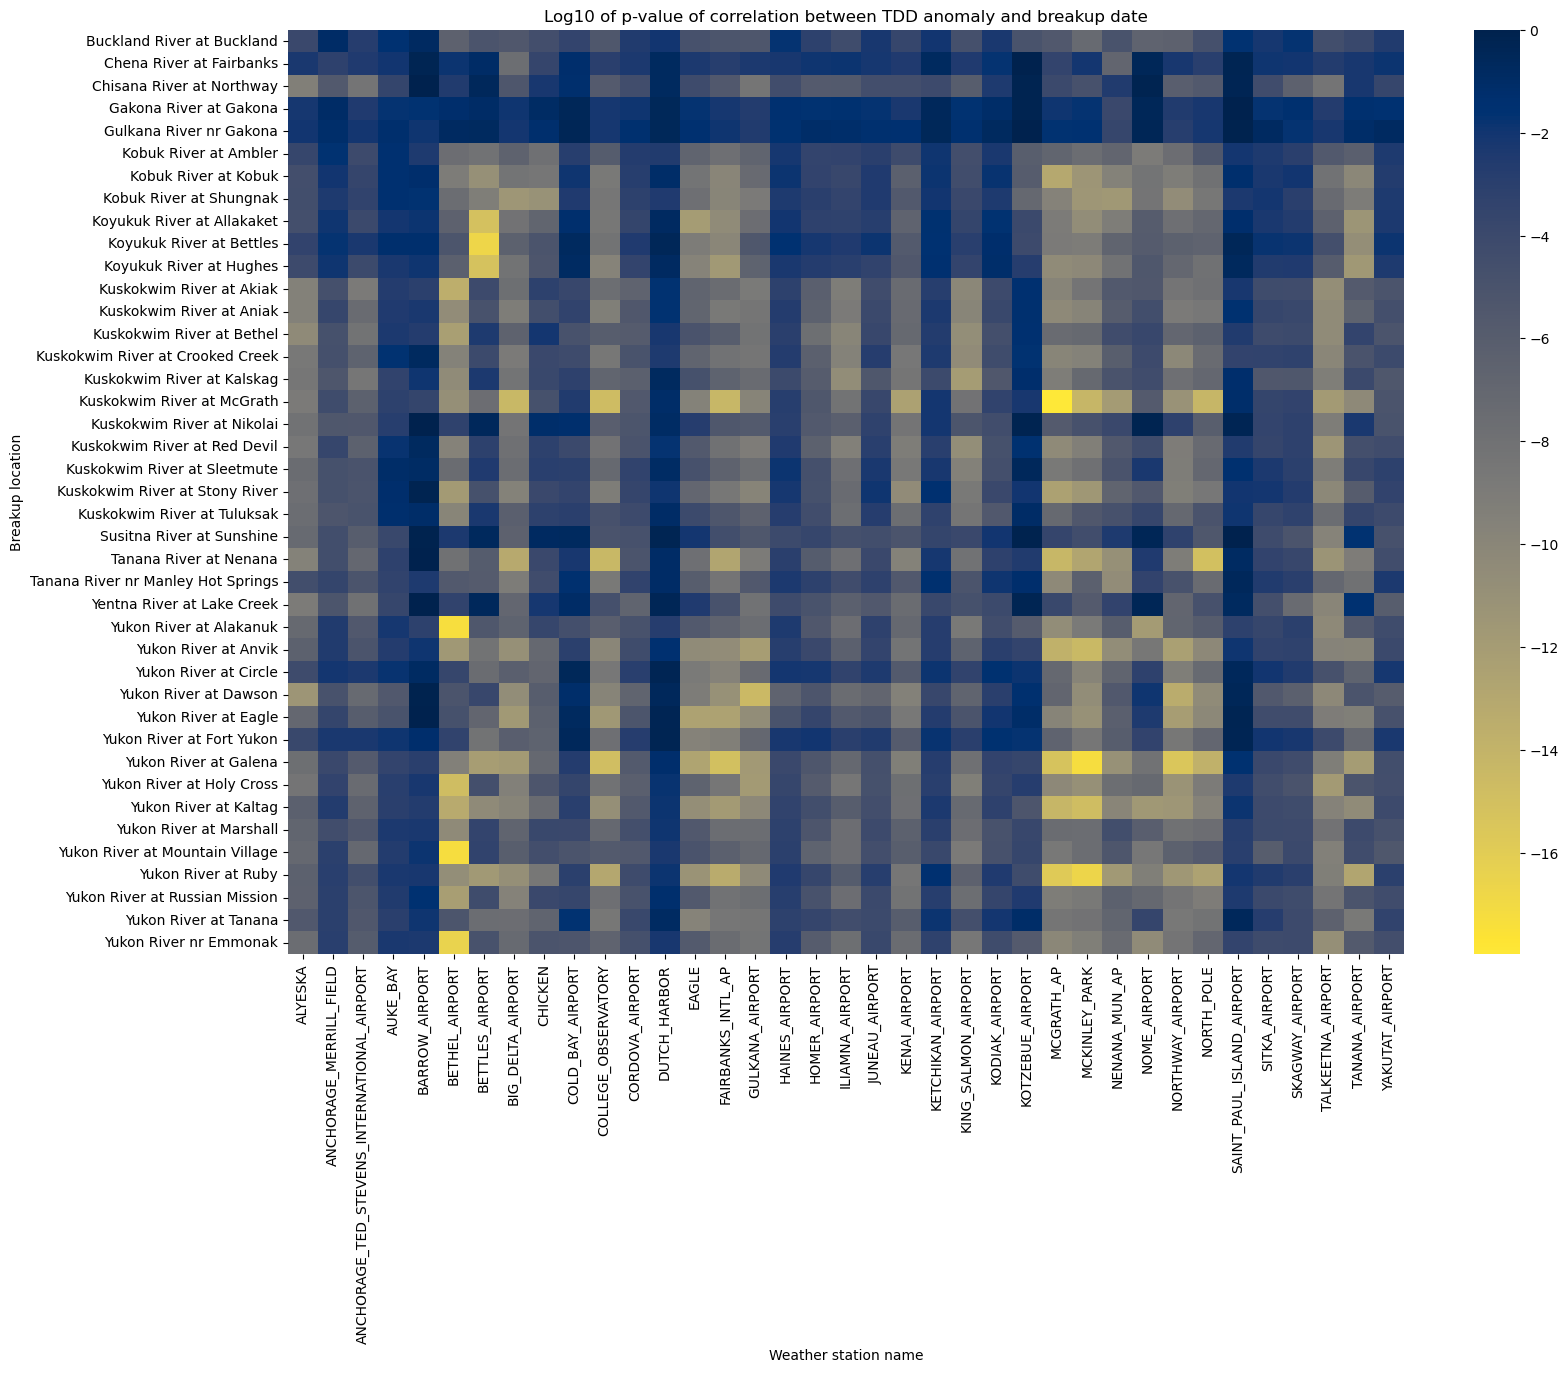

In [ ]:
plt.subplots(figsize=(18,12))
sb.heatmap(
    np.log10(resultsDF_p), 
    cmap='cividis_r', xticklabels=True, yticklabels=True)
plt.xlabel('Weather station name')
plt.ylabel('Breakup location')
plt.title("Log10 of p-value of correlation between TDD anomaly and breakup date")

In [ ]:
Tops = pd.DataFrame(
    resultsDF_r2.apply(
        lambda x:list(resultsDF_r2.columns[np.array(x).argsort()[:][:5]]), axis=1).to_list(),  columns=['Top1', 'Top2', 'Top3', 'Top4', 'Top5'])
Tops.index = resultsDF_r2.index
Tops 

,Top1,Top2,Top3,Top4,Top5
location,,,,,
Buckland River at Buckland,ANCHORAGE_MERRILL_FIELD,SITKA_AIRPORT,KENAI_AIRPORT,TANANA_AIRPORT,TALKEETNA_AIRPORT
Colville River at Colville Village,EAGLE,SITKA_AIRPORT,NORTH_POLE,KENAI_AIRPORT,TANANA_AIRPORT
Colville River at Umiat,NOME_AIRPORT,TANANA_AIRPORT,SITKA_AIRPORT,KENAI_AIRPORT,CHICKEN
Kobuk River at Ambler,ANCHORAGE_MERRILL_FIELD,SITKA_AIRPORT,KENAI_AIRPORT,TALKEETNA_AIRPORT,TANANA_AIRPORT
Kobuk River at Kobuk,ANCHORAGE_MERRILL_FIELD,SITKA_AIRPORT,KENAI_AIRPORT,TALKEETNA_AIRPORT,GULKANA_AIRPORT
Kobuk River at Shungnak,SITKA_AIRPORT,ANCHORAGE_MERRILL_FIELD,KENAI_AIRPORT,TALKEETNA_AIRPORT,GULKANA_AIRPORT
Koyukuk River at Allakaket,ANCHORAGE_MERRILL_FIELD,SITKA_AIRPORT,GULKANA_AIRPORT,TALKEETNA_AIRPORT,KENAI_AIRPORT
Koyukuk River at Bettles,SITKA_AIRPORT,ANCHORAGE_MERRILL_FIELD,TALKEETNA_AIRPORT,GULKANA_AIRPORT,KENAI_AIRPORT
Koyukuk River at Hughes,ANCHORAGE_MERRILL_FIELD,SITKA_AIRPORT,KENAI_AIRPORT,TALKEETNA_AIRPORT,KOTZEBUE_AIRPORT


Now for 15 days before breakupm

In [ ]:
breakup_anomaly_offset = breakup.copy()

for pth in tdd:
    stationname = pth.stem[:-17]
    teststationDF = pd.read_csv(pth, skiprows=4, index_col=0)
    breakup_anomaly_offset[stationname] = breakup_anomaly_offset.apply(
        lambda row: retrieve_dd_anomaly(row, stationname, teststationDF, offset=10), axis=1)

In [ ]:
returnrec = calculate_corr(breakupDF=breakup_anomaly_offset)

/Users/chris/mambaforge/envs/fiweps/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [ ]:
resultsDF_p_offset = pd.DataFrame.from_records(returnrec).pivot(
    index='location', columns='stationname', values='pvalue').fillna(1.0)
resultsDF_r2_offset = pd.DataFrame.from_records(returnrec).pivot(
    index='location', columns='stationname', values='r2value').fillna(0.0)

In [ ]:
with open(outpath / "breakupdayminus15_TDD_corr_pvalues.csv", "w") as dst:
    dst.write("# Correlations between TDD anomalies 15 days before breakup, and breakup day \n")
    dst.write("# For all selected sites and stations\n")
    dst.write("# \n")
    resultsDF_p_offset.to_csv(dst)
with open(outpath / "breakupdayminus15_TDD_corr_r2values.csv", "w") as dst:
    dst.write("# Correlation R2 between TDD anomalies 15 days before breakup, and breakup day \n")
    dst.write("# For all selected sites and stations\n")
    dst.write("# \n")
    resultsDF_r2_offset.to_csv(dst)   

Text(0.5, 1.0, 'Pearson Rˆ2 of correlation between TDD anomaly 15 days before breakup date, and breakup date')

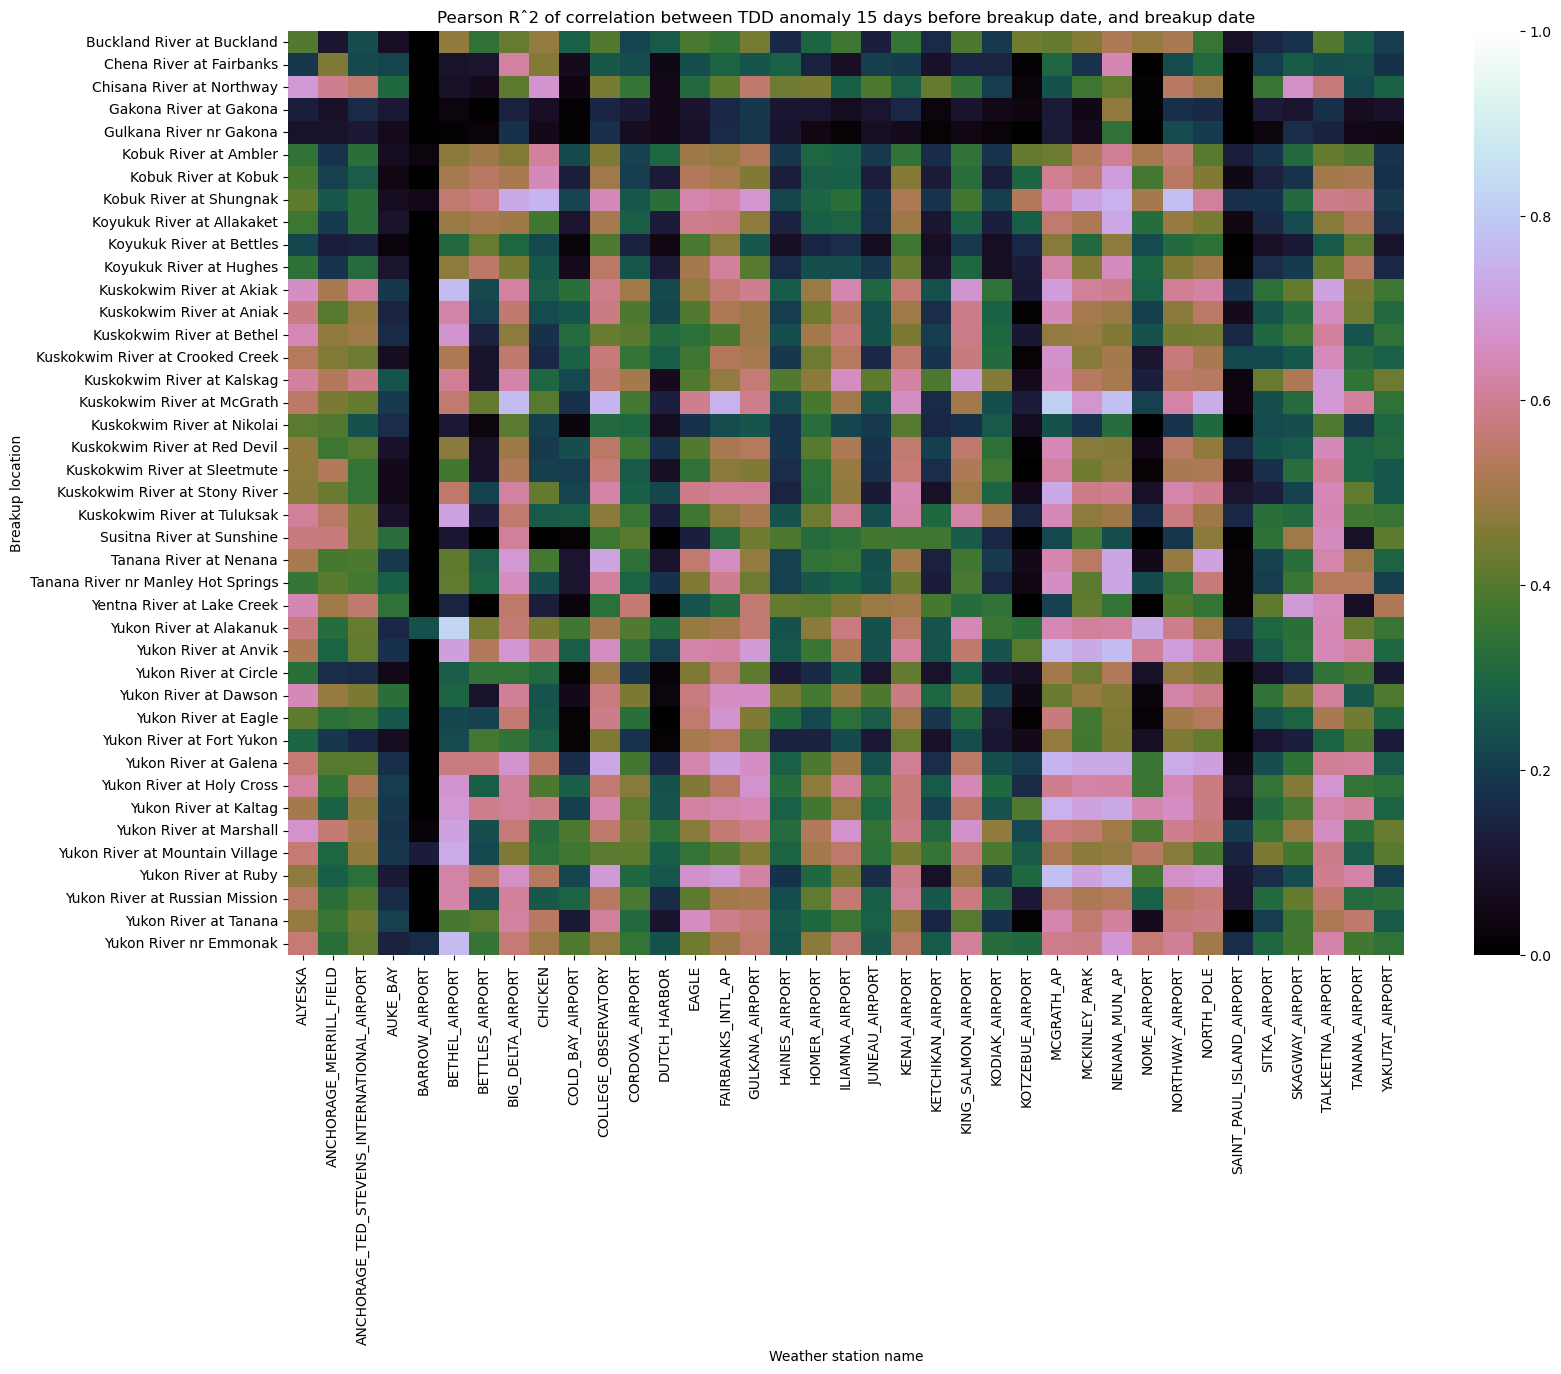

In [ ]:
plt.subplots(figsize=(18,12))
sb.heatmap(
    resultsDF_r2_offset, 
    cmap='cubehelix', xticklabels=True, yticklabels=True, vmin=0, vmax=1)
plt.xlabel('Weather station name')
plt.ylabel('Breakup location')
plt.title("Pearson Rˆ2 of correlation between TDD anomaly 15 days before breakup date, and breakup date")

Now for April 15th, or May 1, or whatever.

In [ ]:
datestr = "04-15"
textstr = "April 15"
fnstr = textstr.replace(" ", "")

In [ ]:
breakup_anomaly_fixed = breakup.copy()

for pth in tdd:
    stationname = pth.stem[:-17]
    teststationDF = pd.read_csv(pth, skiprows=4, index_col=0)
    breakup_anomaly_fixed[stationname] = breakup_anomaly_fixed.apply(
        lambda row: retrieve_tdd_anomaly_fixed(row, stationname, teststationDF, datestr), axis=1)
    # breakup_anomaly_fixed[stationname] = breakup_anomaly_fixed.apply(
    #     lambda row: retrieve_tdd_anomaly_fixed(row, stationname, teststationDF, "04-15"), axis=1)

In [ ]:
returnrec = calculate_corr(breakupDF=breakup_anomaly_fixed)

In [ ]:
resultsDF_p_fixed = pd.DataFrame.from_records(returnrec).pivot(
    index='location', columns='stationname', values='pvalue').fillna(1.0)
resultsDF_r2_fixed = pd.DataFrame.from_records(returnrec).pivot(
    index='location', columns='stationname', values='r2value').fillna(0.0)

In [ ]:
with open(outpath / f"{fnstr}_TDD_corr_pvalues.csv", "w") as dst:
    dst.write(f"# Correlations between TDD anomalies on {textstr}, and breakup day \n")
    dst.write("# For all selected sites and stations\n")
    dst.write("# \n")
    resultsDF_p_fixed.to_csv(dst)
with open(outpath / f"{fnstr}_TDD_corr_r2values.csv", "w") as dst:
    dst.write(f"# Correlation R2 between TDD anomalies on {textstr}, and breakup day \n")
    dst.write("# For all selected sites and stations\n")
    dst.write("# \n")
    resultsDF_r2_fixed.to_csv(dst)   
    

Text(0.5, 1.0, 'Pearson Rˆ2 of correlation between TDD anomaly on April 15, and breakup date')

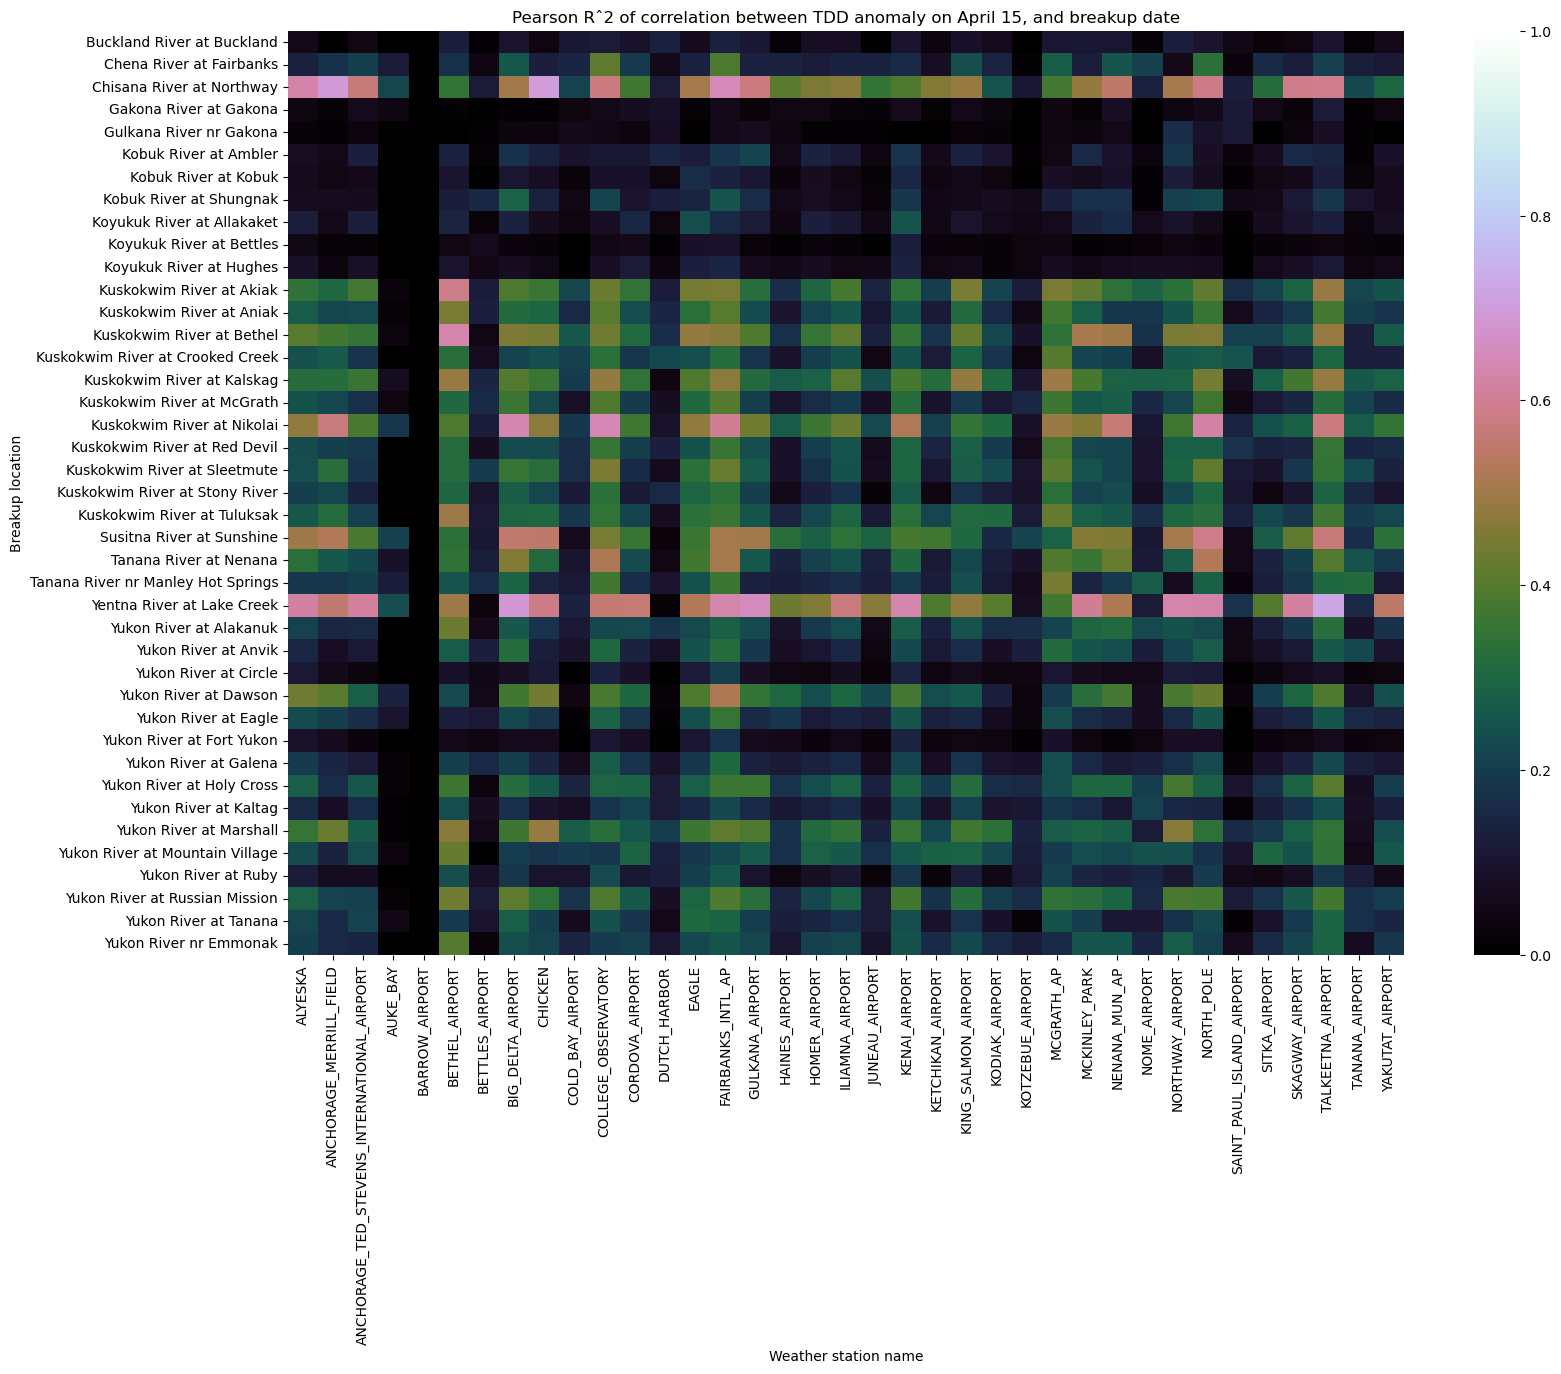

In [ ]:
plt.subplots(figsize=(18,12))
sb.heatmap(
    resultsDF_r2_fixed, 
    cmap='cubehelix', xticklabels=True, yticklabels=True, vmin=0, vmax=1)
plt.xlabel('Weather station name')
plt.ylabel('Breakup location')
plt.title(f"Pearson Rˆ2 of correlation between TDD anomaly on {textstr}, and breakup date")

### Write top correlations to files

In [ ]:
results_r2_dict = resultsDF_r2.T.to_dict()
topstations_breakupday = {}
for location in results_r2_dict:
    topstations_breakupday[location] = dict(sorted(results_r2_dict[location].items(), key=lambda x: -x[1])[:5])

with open(outpath / "beststations_TDD_breakupday.json", "w") as dst:
    json.dump(topstations_breakupday, dst, indent=2)

In [ ]:
results_r2_offset_dict = resultsDF_r2_offset.T.to_dict()
topstations_breakupdayminus15 = {}
for location in results_r2_dict:
    topstations_breakupdayminus15[location] = dict(sorted(results_r2_offset_dict[location].items(), key=lambda x: -x[1])[:5])

with open(outpath / "beststations_TDD_breakupdayminus15.json", "w") as dst:
    json.dump(topstations_breakupdayminus15, dst, indent=2)

In [ ]:
results_r2_April25_dict = resultsDF_r2_fixed.T.to_dict()
topstations_April25 = {}
for location in results_r2_April25_dict:
    topstations_April25[location] = dict(sorted(results_r2_April25_dict[location].items(), key=lambda x: -x[1])[:5])

with open(outpath / "beststations_TDD_April25.json", "w") as dst:
    json.dump(topstations_April25, dst, indent=2)

In [ ]:
results_r2_April15_dict = resultsDF_r2_fixed.T.to_dict()
topstations_April15 = {}
for location in results_r2_April15_dict:
    topstations_April15[location] = dict(sorted(results_r2_April15_dict[location].items(), key=lambda x: -x[1])[:5])

with open(outpath / "beststations_TDD_April15.json", "w") as dst:
    json.dump(topstations_April15, dst, indent=2)

In [ ]:
import itertools

In [ ]:
maxN = 5
resultsdicts = {"breakupday": topstations_breakupday, 
                "breakupdayminus15": topstations_breakupdayminus15, 
                "April25": topstations_April25, 
                "April15": topstations_April15}

roundrobin = itertools.cycle(resultsdicts)

selectedstations = {}
locations = resultsdicts["breakupday"].keys()
for location in locations:
    print(f"Working on {location}")
    selectedstations[location] = set()
    ii = 0
    jj = 0
    for label in roundrobin:
        dict = resultsdicts[label]
        print(f"For {label}...")
        try:
            print(f"Retrieving element {ii}: {sorted(dict[location].items(), key=lambda x: -x[1])[ii][0]}")
            selectedstations[location].add(sorted(dict[location].items(), key=lambda x: -x[1])[ii][0])
        except IndexError:
            continue
        jj += 1
        ii = jj // 4 
        if len(selectedstations[location]) == maxN:
            selectedstations[location] = list(selectedstations[location])
            break


Working on Buckland River at Buckland
For breakupday...
Retrieving element 0: NENANA_MUN_AP
For breakupdayminus15...
Retrieving element 0: NENANA_MUN_AP
For April25...
Retrieving element 0: KOTZEBUE_AIRPORT
For April15...
Retrieving element 0: FAIRBANKS_INTL_AP
For breakupday...
Retrieving element 1: MCKINLEY_PARK
For breakupdayminus15...
Retrieving element 1: NORTHWAY_AIRPORT
Working on Chena River at Fairbanks
For April25...
Retrieving element 0: NENANA_MUN_AP
For April15...
Retrieving element 0: COLLEGE_OBSERVATORY
For breakupday...
Retrieving element 0: NENANA_MUN_AP
For breakupdayminus15...
Retrieving element 0: NENANA_MUN_AP
For April25...
Retrieving element 1: COLLEGE_OBSERVATORY
For April15...
Retrieving element 1: FAIRBANKS_INTL_AP
For breakupday...
Retrieving element 1: BIG_DELTA_AIRPORT
For breakupdayminus15...
Retrieving element 1: BIG_DELTA_AIRPORT
For April25...
Retrieving element 2: BIG_DELTA_AIRPORT
For April15...
Retrieving element 2: NORTH_POLE
Working on Chisana Rive

In [ ]:
Tops = pd.DataFrame(
    resultsDF_r2.apply(
        lambda x:list(resultsDF_r2.columns[np.array(x).argsort()[:][:5]]), axis=1).to_list(),  columns=['Top1', 'Top2', 'Top3', 'Top4', 'Top5'])
Tops.index = resultsDF_r2.index
Tops.to_json()

'{"Top1":{"Buckland River at Buckland":"BARROW_AIRPORT","Chena River at Fairbanks":"KOTZEBUE_AIRPORT","Chisana River at Northway":"BARROW_AIRPORT","Gakona River at Gakona":"SAINT_PAUL_ISLAND_AIRPORT","Gulkana River nr Gakona":"KOTZEBUE_AIRPORT","Kobuk River at Ambler":"AUKE_BAY","Kobuk River at Kobuk":"BARROW_AIRPORT","Kobuk River at Shungnak":"AUKE_BAY","Koyukuk River at Allakaket":"DUTCH_HARBOR","Koyukuk River at Bettles":"SAINT_PAUL_ISLAND_AIRPORT","Koyukuk River at Hughes":"SAINT_PAUL_ISLAND_AIRPORT","Kuskokwim River at Akiak":"KOTZEBUE_AIRPORT","Kuskokwim River at Aniak":"KOTZEBUE_AIRPORT","Kuskokwim River at Bethel":"KOTZEBUE_AIRPORT","Kuskokwim River at Crooked Creek":"BARROW_AIRPORT","Kuskokwim River at Kalskag":"DUTCH_HARBOR","Kuskokwim River at McGrath":"SAINT_PAUL_ISLAND_AIRPORT","Kuskokwim River at Nikolai":"BARROW_AIRPORT","Kuskokwim River at Red Devil":"BARROW_AIRPORT","Kuskokwim River at Sleetmute":"KOTZEBUE_AIRPORT","Kuskokwim River at Stony River":"BARROW_AIRPORT","Kus

In [ ]:
selectedstations

{'Buckland River at Buckland': ['FAIRBANKS_INTL_AP',
  'NORTHWAY_AIRPORT',
  'NENANA_MUN_AP',
  'MCKINLEY_PARK',
  'KOTZEBUE_AIRPORT'],
 'Chena River at Fairbanks': ['FAIRBANKS_INTL_AP',
  'NENANA_MUN_AP',
  'BIG_DELTA_AIRPORT',
  'NORTH_POLE',
  'COLLEGE_OBSERVATORY'],
 'Chisana River at Northway': ['SKAGWAY_AIRPORT',
  'ALYESKA',
  'CHICKEN',
  'ANCHORAGE_MERRILL_FIELD',
  'GULKANA_AIRPORT'],
 'Gakona River at Gakona': ['NORTHWAY_AIRPORT',
  'NENANA_MUN_AP',
  'GULKANA_AIRPORT',
  'SAINT_PAUL_ISLAND_AIRPORT',
  'TALKEETNA_AIRPORT'],
 'Gulkana River nr Gakona': ['NORTHWAY_AIRPORT',
  'NENANA_MUN_AP',
  'SAINT_PAUL_ISLAND_AIRPORT',
  'GULKANA_AIRPORT',
  'NORTH_POLE'],
 'Kobuk River at Ambler': ['NORTHWAY_AIRPORT',
  'NENANA_MUN_AP',
  'CHICKEN',
  'GULKANA_AIRPORT',
  'KOTZEBUE_AIRPORT'],
 'Kobuk River at Kobuk': ['NENANA_MUN_AP',
  'EAGLE',
  'KENAI_AIRPORT',
  'CHICKEN',
  'BIG_DELTA_AIRPORT'],
 'Kobuk River at Shungnak': ['FAIRBANKS_INTL_AP',
  'NORTHWAY_AIRPORT',
  'NENANA_MUN_AP'

In [ ]:
with open(outpath / "selectedstations.json", "w") as dst:
    json.dump(selectedstations, dst, indent=2)